In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("base_VAR_trimestrielle.csv")

In [3]:
df

,observation_date,gdp,cpi,unemp,rate_3m,rate_10y
0,1990-03-31,5872.701,128.600,5.2,7.90,8.59
1,1990-06-30,5960.028,129.900,5.2,7.73,8.48
2,1990-09-30,6015.116,132.500,5.9,7.36,8.89
3,1990-12-31,6004.733,134.200,6.3,6.74,8.08
4,1991-03-31,6035.178,134.800,6.8,5.91,8.11
...,...,...,...,...,...,...
136,2024-03-31,28624.069,312.107,3.9,5.24,4.21
137,2024-06-30,29016.714,313.131,4.1,5.24,4.31
138,2024-09-30,29374.914,314.851,4.1,4.72,3.72
139,2024-12-31,29723.864,317.603,4.1,4.27,4.39


In [4]:
df.index

RangeIndex(start=0, stop=141, step=1)

In [5]:
df.index

RangeIndex(start=0, stop=141, step=1)

In [6]:
# Convertir observation_date en datetime 
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Définir cette colonne comme index
df.set_index('observation_date', inplace=True)

## test de stationnarité 

In [7]:
from statsmodels.tsa.stattools import adfuller

for col in ['gdp', 'cpi', 'unemp', 'rate_3m', 'rate_10y']:
    result = adfuller(df[col].dropna())
    print(f"\nVariable : {col}")
    print(f"ADF Statistic = {result[0]:.4f}")
    print(f"p-value = {result[1]:.4f}")



Variable : gdp
ADF Statistic = 3.9976
p-value = 1.0000

Variable : cpi
ADF Statistic = 2.4433
p-value = 0.9990

Variable : unemp
ADF Statistic = -2.4510
p-value = 0.1279

Variable : rate_3m
ADF Statistic = -2.5466
p-value = 0.1045

Variable : rate_10y
ADF Statistic = -2.3236
p-value = 0.1645


In [8]:
# différencier les séries (première différence)
df_diff = df.copy()


# Appliquer la première différence à chaque variable
df_diff = df_diff.diff().dropna()

# Test ADF sur les séries différenciées
from statsmodels.tsa.stattools import adfuller

for col in df_diff.columns:
    result = adfuller(df_diff[col].dropna())
    print(f"\nVariable différenciée : {col}")
    print(f"ADF Statistic = {result[0]:.4f}")
    print(f"p-value = {result[1]:.4f}")


Variable différenciée : gdp
ADF Statistic = -4.9856
p-value = 0.0000

Variable différenciée : cpi
ADF Statistic = -4.4091
p-value = 0.0003

Variable différenciée : unemp
ADF Statistic = -12.3937
p-value = 0.0000

Variable différenciée : rate_3m
ADF Statistic = -4.8232
p-value = 0.0000

Variable différenciée : rate_10y
ADF Statistic = -6.1954
p-value = 0.0000


In [9]:
df_diff

,gdp,cpi,unemp,rate_3m,rate_10y
observation_date,,,,,
1990-06-30,87.327,1.300,0.0,-0.17,-0.11
1990-09-30,55.088,2.600,0.7,-0.37,0.41
1990-12-31,-10.383,1.700,0.4,-0.62,-0.81
1991-03-31,30.445,0.600,0.5,-0.83,0.03
1991-06-30,91.684,1.200,0.1,-0.34,0.17
...,...,...,...,...,...
2024-03-31,327.102,3.372,0.1,0.00,0.19
2024-06-30,392.645,1.024,0.2,0.00,0.10
2024-09-30,358.200,1.720,0.0,-0.52,-0.59


## le model var

In [10]:
from statsmodels.tsa.api import VAR
model = VAR(df_diff)

results = model.fit(1)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Jul, 2025
Time:                     19:02:23
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    5.96818
Nobs:                     139.000    HQIC:                   5.59221
Log likelihood:          -1326.93    FPE:                    207.495
AIC:                      5.33484    Det(Omega_mle):         167.974
--------------------------------------------------------------------
Results for equation gdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              67.921250        32.690167            2.078           0.038
L1.gdp              0.477701         0.167949            2.844           0.004
L1.cpi             21.559370        16.480168            1.308        

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


In [11]:
# test de la non corelation des résudus 
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(results.resid)

for col, val in zip(df_diff.columns, dw):
    print(f"{col} : Durbin-Watson = {val:.3f}")

gdp : Durbin-Watson = 2.018
cpi : Durbin-Watson = 2.109
unemp : Durbin-Watson = 1.923
rate_3m : Durbin-Watson = 2.164
rate_10y : Durbin-Watson = 2.027


donc modèle ne présente pas d'autocorrélation sérieuse dans les résidus.
C’est un bon signe : le modèle VAR est bien spécifié 

In [12]:
A1 = pd.DataFrame(results.coefs[0],
                  index=df_diff.columns,
                  columns=df_diff.columns)


In [13]:
A1

,gdp,cpi,unemp,rate_3m,rate_10y
gdp,0.477701,21.559370,255.608998,184.063765,-9.947408
cpi,0.002730,0.185658,0.837080,0.273666,-0.264321
unemp,-0.000357,-0.015737,-0.245442,-0.486483,-0.093409
rate_3m,0.000096,-0.017795,-0.001879,0.515793,0.066922
rate_10y,0.000419,-0.008007,0.105296,0.014202,-0.014856


In [14]:
const = pd.Series(results.intercept,
                  index=df_diff.columns,
                  name='const')

In [15]:
const

gdp         67.921250
cpi          0.649757
unemp        0.057962
rate_3m     -0.002213
rate_10y    -0.090516
Name: const, dtype: float64

In [16]:
var = (
    pd.concat([A1, const], axis=1) )
     

print(var)

               gdp        cpi       unemp     rate_3m  rate_10y      const
gdp       0.477701  21.559370  255.608998  184.063765 -9.947408  67.921250
cpi       0.002730   0.185658    0.837080    0.273666 -0.264321   0.649757
unemp    -0.000357  -0.015737   -0.245442   -0.486483 -0.093409   0.057962
rate_3m   0.000096  -0.017795   -0.001879    0.515793  0.066922  -0.002213
rate_10y  0.000419  -0.008007    0.105296    0.014202 -0.014856  -0.090516


In [17]:
residual = results.resid.std(axis=0).rename('residual')


In [18]:
residual

gdp         223.210880
cpi           1.409091
unemp         0.659909
rate_3m       0.377266
rate_10y      0.457565
Name: residual, dtype: float64

In [19]:
var.to_csv("var.csv", index=True)

In [20]:
import numpy as np
import pandas as pd

# Extraire la matrice de covariance des résidus
sigma_u = results.sigma_u

# Appliquer la décomposition de Cholesky
var1chol = np.linalg.cholesky(sigma_u)

# Sauvegarder en CSV 
chol_df = pd.DataFrame(var1chol, columns=[f'V{i+1}' for i in range(var1chol.shape[1])])
chol_df.to_csv("var1chol.csv", index=False)

print(chol_df)

           V1        V2        V3        V4        V5
0  227.367864  0.000000  0.000000  0.000000  0.000000
1    0.643940  1.282779  0.000000  0.000000  0.000000
2   -0.578446  0.124524  0.318975  0.000000  0.000000
3    0.043549  0.088965  0.021186  0.370702  0.000000
4    0.092636  0.151110  0.029621  0.209089  0.375801


In [21]:
import os
os.getcwd()


'C:\\Users\\hp\\stage 2eme annee\\ESG\\VAR'

In [22]:
df

,gdp,cpi,unemp,rate_3m,rate_10y
observation_date,,,,,
1990-03-31,5872.701,128.600,5.2,7.90,8.59
1990-06-30,5960.028,129.900,5.2,7.73,8.48
1990-09-30,6015.116,132.500,5.9,7.36,8.89
1990-12-31,6004.733,134.200,6.3,6.74,8.08
1991-03-31,6035.178,134.800,6.8,5.91,8.11
...,...,...,...,...,...
2024-03-31,28624.069,312.107,3.9,5.24,4.21
2024-06-30,29016.714,313.131,4.1,5.24,4.31
2024-09-30,29374.914,314.851,4.1,4.72,3.72


In [23]:
df_diff

,gdp,cpi,unemp,rate_3m,rate_10y
observation_date,,,,,
1990-06-30,87.327,1.300,0.0,-0.17,-0.11
1990-09-30,55.088,2.600,0.7,-0.37,0.41
1990-12-31,-10.383,1.700,0.4,-0.62,-0.81
1991-03-31,30.445,0.600,0.5,-0.83,0.03
1991-06-30,91.684,1.200,0.1,-0.34,0.17
...,...,...,...,...,...
2024-03-31,327.102,3.372,0.1,0.00,0.19
2024-06-30,392.645,1.024,0.2,0.00,0.10
2024-09-30,358.200,1.720,0.0,-0.52,-0.59


## exemple de simulation 

In [24]:
import numpy as np
import pandas as pd

# ──────────────────────────────────────────────────────────────
# Paramètres estimés du modèle VAR
# ──────────────────────────────────────────────────────────────
A = results.coefs[0]                       # (5×5)  matrice A1
c = results.intercept                      # (5,)   constantes
L = np.linalg.cholesky(results.sigma_u)   # (5×5)  matrice de Cholesky

n_steps = 40                               # 10 ans (trimestres)
n_vars  = A.shape[0]

# ──────────────────────────────────────────────────────────────

last_level = df.iloc[-1][df_diff.columns].values   # dernier niveau observé
last_diff  = df_diff.iloc[-1].values               # dernière différence observée

# ──────────────────────────────────────────────────────────────
# Initialisation et paramètres du retour à la moyenne
# ──────────────────────────────────────────────────────────────
alpha = 0.1                                         # force du retour à la moyenne 
mean_diff = df_diff.mean().values                   # moyenne historique des différences

scenarios_diff = np.zeros((n_steps + 1, n_vars))
scenarios_diff[0] = last_diff

# ──────────────────────────────────────────────────────────────
# Simulation avec retour à la moyenne
# ──────────────────────────────────────────────────────────────
for t in range(1, n_steps + 1):
    eps = L @ np.random.normal(size=n_vars)
    scenarios_diff[t] = (
        A @ scenarios_diff[t-1]
        + c
        + alpha * (mean_diff - scenarios_diff[t-1])  # retour à la moyenne
        + eps
    )

# ──────────────────────────────────────────────────────────────
#  Reconstitution des niveaux
#    Y_{T+h} = Y_T + Σ ΔY
sim_diff_df = pd.DataFrame(scenarios_diff, columns=df_diff.columns)

sim_levels_df = sim_diff_df.cumsum().add(last_level, axis=1)

future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=3),
    periods=n_steps + 1,
    freq='Q'
)
sim_levels_df.index = future_dates

# ──────────────────────────────────────────────────────────────
# 6. Affichage rapide
# ──────────────────────────────────────────────────────────────
print(sim_levels_df.head())


                     gdp         cpi     unemp   rate_3m  rate_10y
2025-06-30  30200.230000  321.627000  4.300000  4.130000  4.170000
2025-09-30  30140.772163  323.516126  5.375402  4.842674  5.100961
2025-12-31  30628.162891  324.144424  4.734339  5.450531  5.107562
2026-03-31  30164.332959  323.545609  6.385277  5.837049  5.821283
2026-06-30  30815.227127  323.652011  5.142413  6.641909  5.736055


C:\Users\hp\AppData\Local\Temp\ipykernel_25836\634443345.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(


In [25]:
sim_levels_df

,gdp,cpi,unemp,rate_3m,rate_10y
2025-06-30,30200.230000,321.627000,4.300000,4.130000,4.170000
2025-09-30,30140.772163,323.516126,5.375402,4.842674,5.100961
2025-12-31,30628.162891,324.144424,4.734339,5.450531,5.107562
2026-03-31,30164.332959,323.545609,6.385277,5.837049,5.821283
2026-06-30,30815.227127,323.652011,5.142413,6.641909,5.736055
2026-09-30,31183.343874,324.807071,3.891437,6.455874,5.160113
2026-12-31,31196.852705,325.442677,3.959750,6.708347,4.522321
2027-03-31,31620.607853,329.348592,3.820869,6.643649,4.396866
2027-06-30,31752.213492,330.832926,3.946262,6.666090,4.604068
2027-09-30,32253.154158,332.551696,3.327844,6.801929,4.993442


FileNotFoundError: [Errno 2] No such file or directory: 'Images/simulated_vs_real_gdp.png'

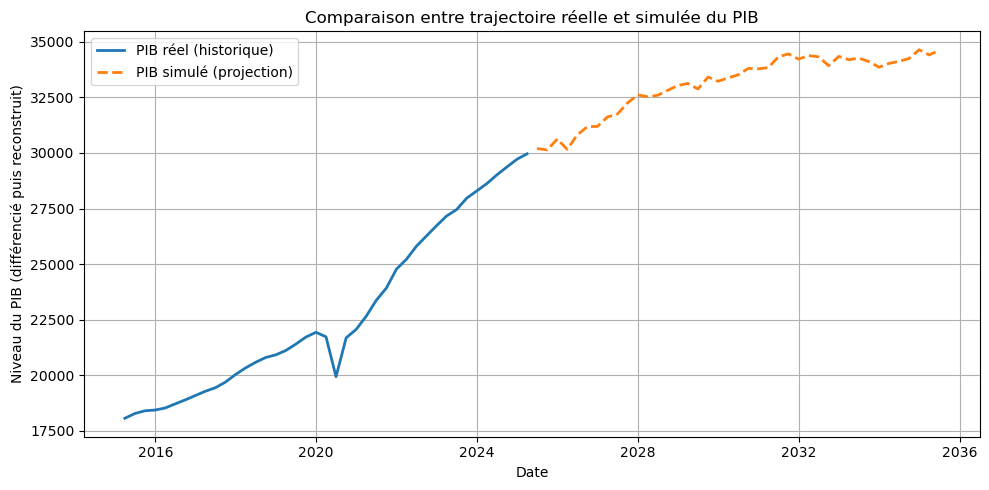

In [26]:
import matplotlib.pyplot as plt

# 1. Série réelle sur les dernières années
historical = df['gdp'].loc['2015-01-01':]

# 2. Série simulée générée par le modèle VAR (sim_levels_df)
simulated = sim_levels_df['gdp']

# 3. Concaténer les deux séries pour affichage
plt.figure(figsize=(10, 5))
plt.plot(historical.index, historical.values, label='PIB réel (historique)', linewidth=2)
plt.plot(simulated.index, simulated.values, label='PIB simulé (projection)', linestyle='--', linewidth=2)

plt.title("Comparaison entre trajectoire réelle et simulée du PIB")
plt.xlabel("Date")
plt.ylabel("Niveau du PIB (différencié puis reconstruit)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Sauvegarder si tu veux l'intégrer dans LaTeX
plt.savefig("Images/simulated_vs_real_gdp.png", dpi=300)
plt.show()
